# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!mkdir -p data
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.67KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

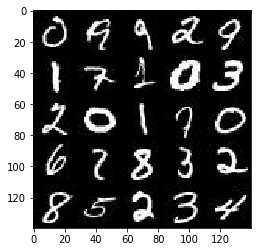

In [1]:
show_n_images = 25
data_dir = './data'
import helper

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

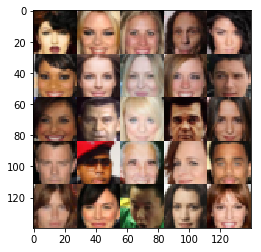

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name="real_input")
    z_input = tf.placeholder(tf.float32, [None, z_dim], name="z_input")
    l_rate = tf.placeholder(tf.float32, name="l_rate")

    return real_input, z_input, l_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [5]:
import numpy as np
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):        
        #Input is 28x28x3
        x = tf.layers.conv2d(images, filters=32, kernel_size=4, strides=1, padding="same")
        x = tf.maximum(alpha * x, x, "input")
        # 28x28x32
        
        #print(x.shape)
        assert x.shape[1:] == (28, 28, 32)
        
        cl0 = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding="same")
        cl0 = tf.layers.batch_normalization(cl0, training=True)
        cl0 = tf.maximum(alpha * cl0, cl0, "cl0")
        # 14x14x64
        
        assert cl0.shape[1:] == (14, 14, 64)
        
        cl1 = tf.layers.conv2d(cl0, filters=128, kernel_size=4, strides=2, padding="same")
        cl1 = tf.layers.batch_normalization(cl1, training=True)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 7x7x128
        
        #print(cl1.shape)
        assert cl1.shape[1:] == [7, 7, 128]
        
        cl2 = tf.layers.conv2d(cl1, filters=256, kernel_size=4, strides=2, padding="same")
        cl2 = tf.layers.batch_normalization(cl2, training=True)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 4x4x256
        
        #print(cl2.shape)
        assert cl2.shape[1: ] == [4, 4, 256]
        
        cl3 = tf.layers.conv2d(cl2, filters=512, kernel_size=4, strides=2, padding="same")
        cl3 = tf.layers.batch_normalization(cl3, training=True)
        cl3 = tf.maximum(alpha * cl3, cl3, "cl3")
        # 2x2x512
        
        #print(cl3.shape)
        assert cl3.shape[1: ] == [2, 2, 512]

        # Flatten it
        flat = tf.reshape(cl3, (-1, int(np.prod(cl3.shape[1:]))))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    with tf.variable_scope("generator", reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*1024)
        x = tf.reshape(x, (-1, 4, 4, 1024))
        x = tf.layers.batch_normalization(x, training=not is_train)
        # Leaky ReLU
        x = tf.maximum(alpha * x, x, "input")
        # 4x4x1024 now
        
        cl0 = tf.image.resize_images(x, [12, 12], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        cl0 = tf.pad(cl0, [[0, 0], [1, 1,], [1, 1], [0, 0]], "SYMMETRIC")
        cl0 = tf.layers.conv2d(cl0, 512, 4, 2, 'same')
        # 7x7x512
        #print(cl0.shape)
        
        cl1 = tf.layers.conv2d_transpose(cl0, 256, 4, 2, 'same')
        cl1 = tf.layers.batch_normalization(cl1, training=not is_train)
        cl1 = tf.maximum(alpha * cl1, cl1, "cl1")
        # 14x14x256 now
        
        #print(cl1.shape)
        
        cl2 = tf.layers.conv2d_transpose(cl1, 128, 4, 2, 'same')
        cl2 = tf.layers.batch_normalization(cl2, training=not is_train)
        cl2 = tf.maximum(alpha * cl2, cl2, "cl2")
        # 28x28x128 now
        
        #print(cl2.shape)
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(cl2, out_channel_dim, 4, 1, 'same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function 
    # Taken as is from the DCGAN lesson
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    # Taken as is from the DCGAN lesson
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
                           print_every = 10, draw_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    losses = []
    
    if data_image_mode == "RGB":
        channels = 3
    elif data_image_mode == "L":
        channels = 1
    else:
        assert False, "Image mode not recognised."
        
    steps = 0
   
    # Building the Model
    real_input, z_input, l_rate = model_inputs(data_shape[1], data_shape[2], channels, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images * 2
                # TODO: Train Model               
                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, real_input: batch_images, l_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % draw_every == 0:
                    show_generator_output(sess, 25, z_input, channels, data_image_mode)
           
        show_generator_output(sess, 25, z_input, channels, data_image_mode)    
        
        return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0729... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 0.4369... Generator Loss: 2.0377
Epoch 1/2... Discriminator Loss: 0.4297... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 0.2060... Generator Loss: 2.1993
Epoch 1/2... Discriminator Loss: 0.2572... Generator Loss: 1.8799
Epoch 1/2... Discriminator Loss: 0.0974... Generator Loss: 2.8116
Epoch 1/2... Discriminator Loss: 0.0524... Generator Loss: 3.6300
Epoch 1/2... Discriminator Loss: 0.0456... Generator Loss: 3.7704
Epoch 1/2... Discriminator Loss: 0.0329... Generator Loss: 4.5665
Epoch 1/2... Discriminator Loss: 0.0428... Generator Loss: 4.0233


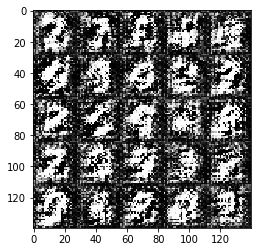

Epoch 1/2... Discriminator Loss: 0.1059... Generator Loss: 2.7552
Epoch 1/2... Discriminator Loss: 1.2367... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 0.1908... Generator Loss: 2.3156
Epoch 1/2... Discriminator Loss: 0.2494... Generator Loss: 2.1819
Epoch 1/2... Discriminator Loss: 0.2161... Generator Loss: 2.2288
Epoch 1/2... Discriminator Loss: 0.1229... Generator Loss: 3.0185
Epoch 1/2... Discriminator Loss: 0.1508... Generator Loss: 2.9530
Epoch 1/2... Discriminator Loss: 0.1384... Generator Loss: 2.8191
Epoch 1/2... Discriminator Loss: 0.1765... Generator Loss: 3.2601
Epoch 1/2... Discriminator Loss: 0.2448... Generator Loss: 3.5271


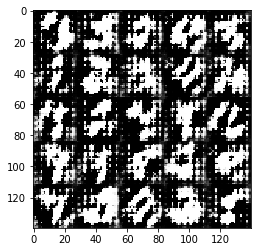

Epoch 1/2... Discriminator Loss: 0.2146... Generator Loss: 2.4557
Epoch 1/2... Discriminator Loss: 0.2759... Generator Loss: 2.0281
Epoch 1/2... Discriminator Loss: 0.4523... Generator Loss: 1.5993
Epoch 1/2... Discriminator Loss: 0.1677... Generator Loss: 2.7140
Epoch 1/2... Discriminator Loss: 0.2960... Generator Loss: 2.4747
Epoch 1/2... Discriminator Loss: 0.5987... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 0.2033... Generator Loss: 3.1427
Epoch 1/2... Discriminator Loss: 0.3086... Generator Loss: 1.9274
Epoch 1/2... Discriminator Loss: 0.2446... Generator Loss: 2.3740
Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 3.1588


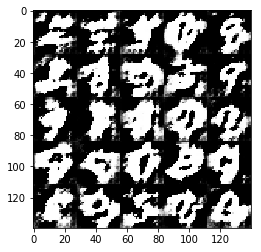

Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 1.9906
Epoch 1/2... Discriminator Loss: 0.2239... Generator Loss: 2.5160
Epoch 1/2... Discriminator Loss: 0.2436... Generator Loss: 2.1603
Epoch 1/2... Discriminator Loss: 0.2627... Generator Loss: 2.6133
Epoch 1/2... Discriminator Loss: 0.1870... Generator Loss: 2.3299
Epoch 1/2... Discriminator Loss: 0.3167... Generator Loss: 2.0566
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 1.4678
Epoch 1/2... Discriminator Loss: 0.1342... Generator Loss: 2.9621
Epoch 1/2... Discriminator Loss: 0.2402... Generator Loss: 3.0028
Epoch 1/2... Discriminator Loss: 0.9505... Generator Loss: 0.8784


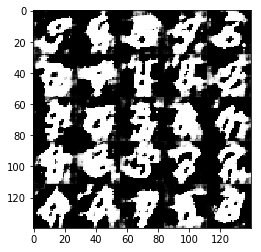

Epoch 1/2... Discriminator Loss: 0.2336... Generator Loss: 4.1379
Epoch 1/2... Discriminator Loss: 0.2769... Generator Loss: 2.0449
Epoch 1/2... Discriminator Loss: 0.2631... Generator Loss: 2.0943
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 1.6622
Epoch 1/2... Discriminator Loss: 0.2795... Generator Loss: 2.0701
Epoch 1/2... Discriminator Loss: 0.1685... Generator Loss: 3.2958
Epoch 1/2... Discriminator Loss: 0.1428... Generator Loss: 2.8361
Epoch 1/2... Discriminator Loss: 0.1599... Generator Loss: 2.9780
Epoch 1/2... Discriminator Loss: 0.2398... Generator Loss: 2.3071
Epoch 1/2... Discriminator Loss: 0.2053... Generator Loss: 3.3052


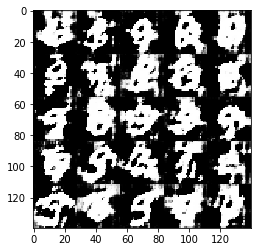

Epoch 1/2... Discriminator Loss: 0.0760... Generator Loss: 3.8548
Epoch 1/2... Discriminator Loss: 0.1821... Generator Loss: 3.0006
Epoch 1/2... Discriminator Loss: 0.2525... Generator Loss: 2.2234
Epoch 1/2... Discriminator Loss: 0.1095... Generator Loss: 3.9113
Epoch 1/2... Discriminator Loss: 0.4959... Generator Loss: 1.3265
Epoch 1/2... Discriminator Loss: 0.7401... Generator Loss: 0.9033
Epoch 1/2... Discriminator Loss: 0.1840... Generator Loss: 2.7202
Epoch 1/2... Discriminator Loss: 0.3052... Generator Loss: 1.8304
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.5744
Epoch 1/2... Discriminator Loss: 0.1704... Generator Loss: 2.6677


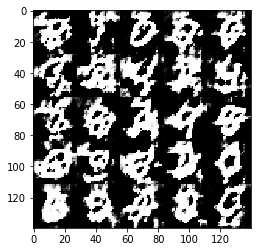

Epoch 1/2... Discriminator Loss: 0.2425... Generator Loss: 4.7063
Epoch 1/2... Discriminator Loss: 0.1685... Generator Loss: 2.8077
Epoch 1/2... Discriminator Loss: 0.1573... Generator Loss: 4.1766
Epoch 1/2... Discriminator Loss: 0.3129... Generator Loss: 1.8781
Epoch 1/2... Discriminator Loss: 0.2414... Generator Loss: 2.4900
Epoch 1/2... Discriminator Loss: 0.2528... Generator Loss: 2.5520
Epoch 1/2... Discriminator Loss: 0.1520... Generator Loss: 3.3495
Epoch 1/2... Discriminator Loss: 1.2432... Generator Loss: 0.4610
Epoch 1/2... Discriminator Loss: 0.2717... Generator Loss: 2.0518
Epoch 1/2... Discriminator Loss: 0.4171... Generator Loss: 1.8203


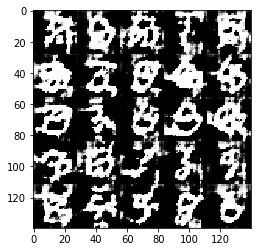

Epoch 1/2... Discriminator Loss: 0.3644... Generator Loss: 1.5632
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 3.0700
Epoch 1/2... Discriminator Loss: 0.3587... Generator Loss: 1.6395
Epoch 1/2... Discriminator Loss: 0.2458... Generator Loss: 2.5679
Epoch 1/2... Discriminator Loss: 0.2762... Generator Loss: 3.0778
Epoch 1/2... Discriminator Loss: 0.7543... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 0.2567... Generator Loss: 2.0371
Epoch 1/2... Discriminator Loss: 0.2240... Generator Loss: 2.0144
Epoch 1/2... Discriminator Loss: 0.4762... Generator Loss: 4.2505
Epoch 1/2... Discriminator Loss: 0.6010... Generator Loss: 1.1096


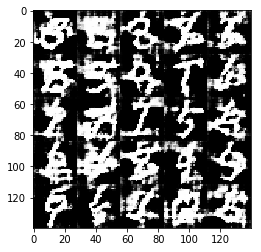

Epoch 1/2... Discriminator Loss: 0.3744... Generator Loss: 3.6199
Epoch 1/2... Discriminator Loss: 0.1849... Generator Loss: 2.7455
Epoch 1/2... Discriminator Loss: 0.2570... Generator Loss: 2.5879
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 4.8400
Epoch 1/2... Discriminator Loss: 0.2716... Generator Loss: 2.2337
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.2845... Generator Loss: 2.2111
Epoch 1/2... Discriminator Loss: 0.3227... Generator Loss: 2.1477
Epoch 1/2... Discriminator Loss: 0.2929... Generator Loss: 1.8184
Epoch 1/2... Discriminator Loss: 0.3914... Generator Loss: 2.0198


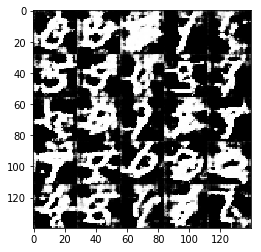

Epoch 1/2... Discriminator Loss: 1.1016... Generator Loss: 0.5516
Epoch 1/2... Discriminator Loss: 0.2626... Generator Loss: 2.4631
Epoch 1/2... Discriminator Loss: 0.2799... Generator Loss: 2.2097
Epoch 2/2... Discriminator Loss: 0.2430... Generator Loss: 2.1182
Epoch 2/2... Discriminator Loss: 0.7006... Generator Loss: 3.6504
Epoch 2/2... Discriminator Loss: 0.5583... Generator Loss: 1.2131
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 1.4260
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 0.4149... Generator Loss: 1.5171
Epoch 2/2... Discriminator Loss: 0.4141... Generator Loss: 1.4941


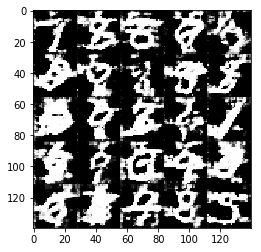

Epoch 2/2... Discriminator Loss: 0.1797... Generator Loss: 2.8757
Epoch 2/2... Discriminator Loss: 0.2398... Generator Loss: 2.3098
Epoch 2/2... Discriminator Loss: 0.2826... Generator Loss: 2.0340
Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 1.3187
Epoch 2/2... Discriminator Loss: 0.1400... Generator Loss: 2.6297
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 1.2563
Epoch 2/2... Discriminator Loss: 0.3083... Generator Loss: 1.7636
Epoch 2/2... Discriminator Loss: 0.2915... Generator Loss: 1.7874
Epoch 2/2... Discriminator Loss: 0.2652... Generator Loss: 2.1933
Epoch 2/2... Discriminator Loss: 0.3838... Generator Loss: 2.4413


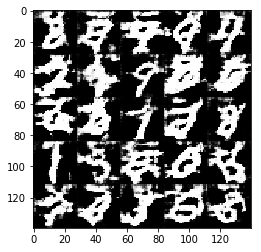

Epoch 2/2... Discriminator Loss: 0.3331... Generator Loss: 1.9035
Epoch 2/2... Discriminator Loss: 0.5961... Generator Loss: 1.0694
Epoch 2/2... Discriminator Loss: 0.2899... Generator Loss: 1.8490
Epoch 2/2... Discriminator Loss: 0.2709... Generator Loss: 1.8288
Epoch 2/2... Discriminator Loss: 0.2352... Generator Loss: 2.1755
Epoch 2/2... Discriminator Loss: 0.3366... Generator Loss: 1.6980
Epoch 2/2... Discriminator Loss: 0.1800... Generator Loss: 2.6045
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 1.5704
Epoch 2/2... Discriminator Loss: 0.2123... Generator Loss: 2.3934
Epoch 2/2... Discriminator Loss: 0.3841... Generator Loss: 1.5285


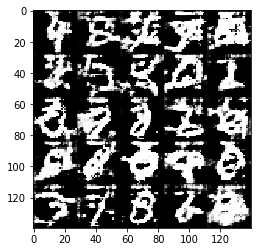

Epoch 2/2... Discriminator Loss: 0.2962... Generator Loss: 1.8558
Epoch 2/2... Discriminator Loss: 0.3449... Generator Loss: 1.5776
Epoch 2/2... Discriminator Loss: 0.4594... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 0.3090... Generator Loss: 1.7976
Epoch 2/2... Discriminator Loss: 0.3468... Generator Loss: 1.6683
Epoch 2/2... Discriminator Loss: 0.5424... Generator Loss: 1.2250
Epoch 2/2... Discriminator Loss: 0.2025... Generator Loss: 2.2676
Epoch 2/2... Discriminator Loss: 0.1580... Generator Loss: 2.7702
Epoch 2/2... Discriminator Loss: 0.1986... Generator Loss: 2.8590
Epoch 2/2... Discriminator Loss: 0.2697... Generator Loss: 1.8256


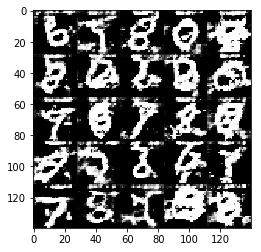

Epoch 2/2... Discriminator Loss: 0.3191... Generator Loss: 1.8428
Epoch 2/2... Discriminator Loss: 0.3305... Generator Loss: 1.6230
Epoch 2/2... Discriminator Loss: 0.4444... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 0.6853
Epoch 2/2... Discriminator Loss: 0.2881... Generator Loss: 1.8252
Epoch 2/2... Discriminator Loss: 1.0291... Generator Loss: 6.0559
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 2.4408
Epoch 2/2... Discriminator Loss: 0.4086... Generator Loss: 1.6860
Epoch 2/2... Discriminator Loss: 0.5933... Generator Loss: 1.1093
Epoch 2/2... Discriminator Loss: 0.3896... Generator Loss: 1.4465


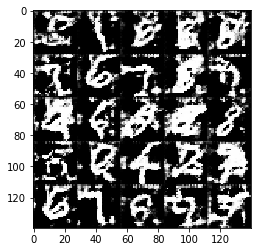

Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 0.3166... Generator Loss: 1.9115
Epoch 2/2... Discriminator Loss: 0.4815... Generator Loss: 1.2573
Epoch 2/2... Discriminator Loss: 0.3045... Generator Loss: 1.7429
Epoch 2/2... Discriminator Loss: 0.1724... Generator Loss: 2.2553
Epoch 2/2... Discriminator Loss: 0.1951... Generator Loss: 2.3220
Epoch 2/2... Discriminator Loss: 0.3737... Generator Loss: 1.4737
Epoch 2/2... Discriminator Loss: 0.3644... Generator Loss: 2.8846
Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 1.5254
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 2.1881


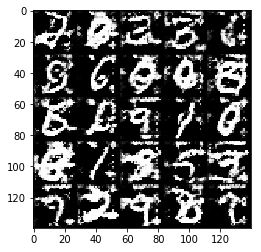

Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 2.4121
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 0.4202... Generator Loss: 1.6479
Epoch 2/2... Discriminator Loss: 0.7879... Generator Loss: 4.6333
Epoch 2/2... Discriminator Loss: 0.3834... Generator Loss: 1.6181
Epoch 2/2... Discriminator Loss: 0.1911... Generator Loss: 2.6290
Epoch 2/2... Discriminator Loss: 0.4144... Generator Loss: 1.5357
Epoch 2/2... Discriminator Loss: 0.3304... Generator Loss: 1.6459
Epoch 2/2... Discriminator Loss: 0.4762... Generator Loss: 1.2715
Epoch 2/2... Discriminator Loss: 0.6392... Generator Loss: 1.2289


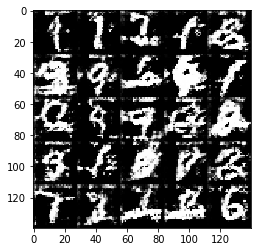

Epoch 2/2... Discriminator Loss: 0.3318... Generator Loss: 1.7047
Epoch 2/2... Discriminator Loss: 0.6051... Generator Loss: 1.0763
Epoch 2/2... Discriminator Loss: 0.4026... Generator Loss: 1.4756
Epoch 2/2... Discriminator Loss: 0.3570... Generator Loss: 1.4631
Epoch 2/2... Discriminator Loss: 0.1651... Generator Loss: 2.4713
Epoch 2/2... Discriminator Loss: 0.1780... Generator Loss: 2.6125
Epoch 2/2... Discriminator Loss: 0.1681... Generator Loss: 2.3993
Epoch 2/2... Discriminator Loss: 0.2036... Generator Loss: 2.2178
Epoch 2/2... Discriminator Loss: 0.2177... Generator Loss: 2.1278
Epoch 2/2... Discriminator Loss: 0.3055... Generator Loss: 1.6961


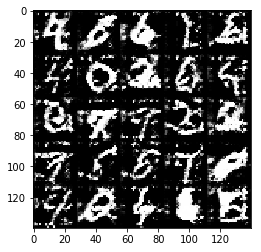

Epoch 2/2... Discriminator Loss: 0.1473... Generator Loss: 2.5582
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 2.1052... Generator Loss: 0.2066
Epoch 2/2... Discriminator Loss: 8.3650... Generator Loss: 13.4207
Epoch 2/2... Discriminator Loss: 0.7790... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.4772... Generator Loss: 2.2978
Epoch 2/2... Discriminator Loss: 0.4779... Generator Loss: 1.3153
Epoch 2/2... Discriminator Loss: 0.5294... Generator Loss: 1.3066
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 0.7928


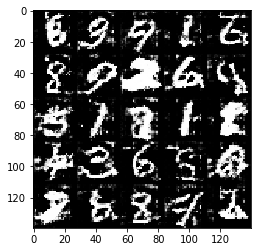

Epoch 2/2... Discriminator Loss: 0.5784... Generator Loss: 1.1208
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 0.7376... Generator Loss: 0.9092
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.1096
Epoch 2/2... Discriminator Loss: 0.3673... Generator Loss: 1.5607


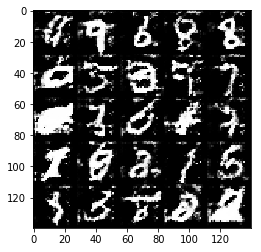

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1525... Generator Loss: 5.1673
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 10.2950
Epoch 1/1... Discriminator Loss: 0.3945... Generator Loss: 5.6900
Epoch 1/1... Discriminator Loss: 0.5176... Generator Loss: 3.3369
Epoch 1/1... Discriminator Loss: 0.2232... Generator Loss: 3.1637
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 6.8743
Epoch 1/1... Discriminator Loss: 1.7121... Generator Loss: 0.3515
Epoch 1/1... Discriminator Loss: 0.2633... Generator Loss: 2.5852
Epoch 1/1... Discriminator Loss: 2.5254... Generator Loss: 0.1341
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.0025


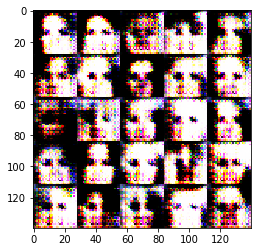

Epoch 1/1... Discriminator Loss: 0.5651... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.0669
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 0.7760... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.9702... Generator Loss: 0.3981
Epoch 1/1... Discriminator Loss: 0.5030... Generator Loss: 1.9756
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 3.3455
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.9529... Generator Loss: 3.9693


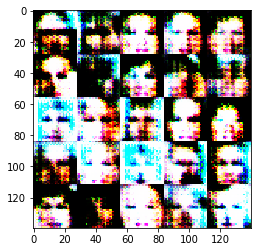

Epoch 1/1... Discriminator Loss: 1.5921... Generator Loss: 3.1896
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.8335
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 2.5125
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 0.5268... Generator Loss: 1.4583
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.8886
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 2.1883


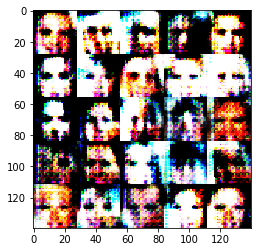

Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 0.9383
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.1677
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.1251
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.8008... Generator Loss: 2.1718
Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.2471
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.6048
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.2880


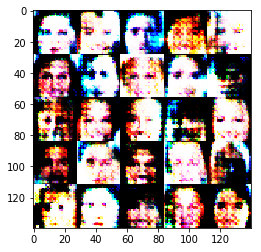

Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.3120
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 0.8886... Generator Loss: 1.3284
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 1.3538
Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.1164
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 1.8478
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 1.0599


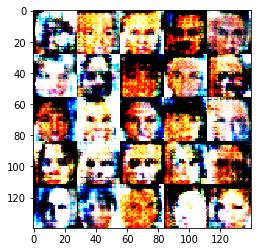

Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.9941... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.3070
Epoch 1/1... Discriminator Loss: 0.7424... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.9683... Generator Loss: 1.3250
Epoch 1/1... Discriminator Loss: 1.0120... Generator Loss: 2.1164
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.6191


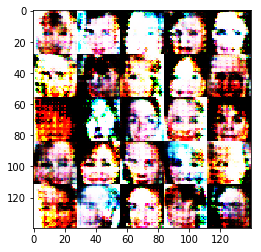

Epoch 1/1... Discriminator Loss: 0.8424... Generator Loss: 1.1247
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 0.9949... Generator Loss: 1.2130
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.0037... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.8181
Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.1959


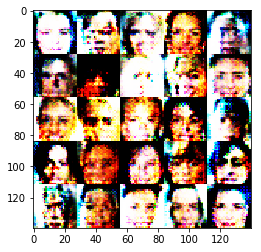

Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.4394
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.9080... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.4789


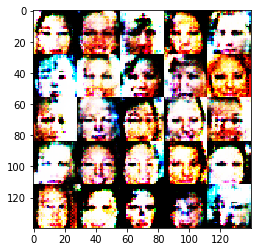

Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 0.8107... Generator Loss: 1.4694
Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 1.5019
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.2982
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 0.9842... Generator Loss: 0.7860


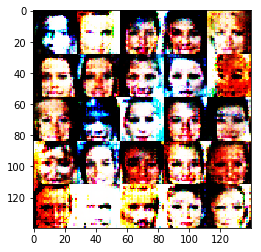

Epoch 1/1... Discriminator Loss: 0.7744... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 0.9193
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.2178
Epoch 1/1... Discriminator Loss: 1.0539... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.0664... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.3033
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.6788


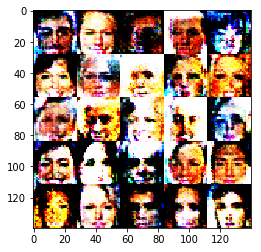

Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.6712
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 0.9174... Generator Loss: 0.8981
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.0801


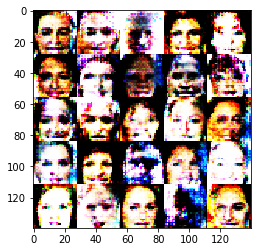

Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.0039... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 1.1117
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 0.8213


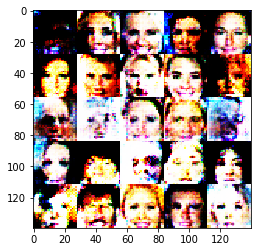

Epoch 1/1... Discriminator Loss: 1.1055... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 0.9518... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.0528... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.0177... Generator Loss: 0.8213


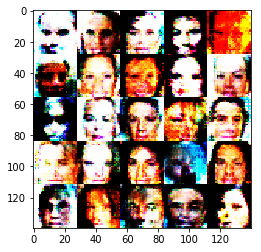

Epoch 1/1... Discriminator Loss: 0.9830... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.4343
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.5515
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 0.9321


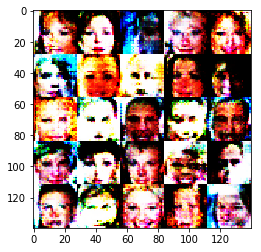

Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.5289
Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.3027... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.0354... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0107... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 0.9281


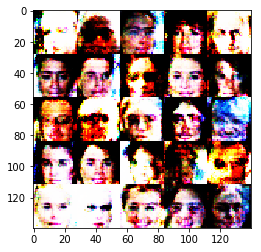

Epoch 1/1... Discriminator Loss: 0.9834... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.4540
Epoch 1/1... Discriminator Loss: 1.0472... Generator Loss: 0.8682


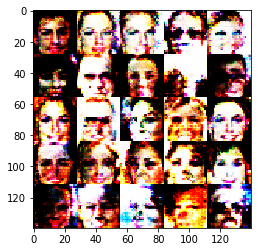

Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.2144... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.8735


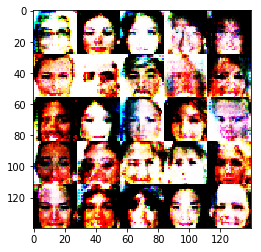

Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9485
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.5294
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7038


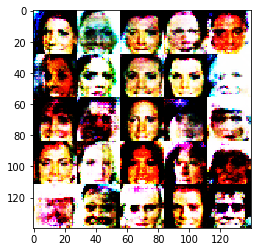

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9871
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.1282... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 1.2218


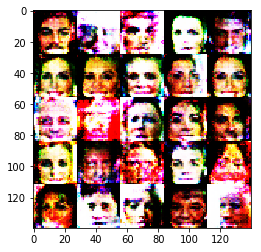

Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 0.8217
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.0370... Generator Loss: 0.9404


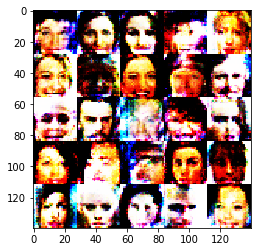

Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.1258
Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 1.0661
Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.6530


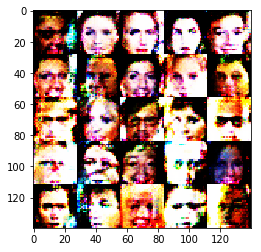

Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.4693
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 1.0112


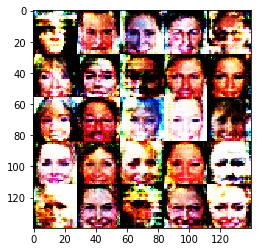

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.5763
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6796


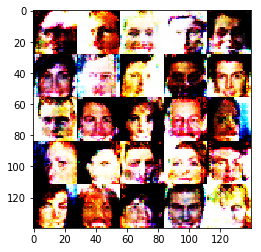

Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.5605


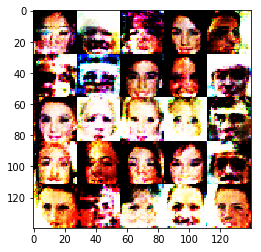

Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 0.9563... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.8489
Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.7574


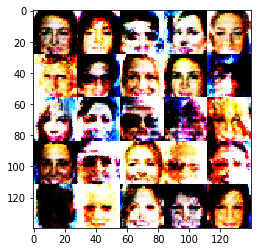

Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0837
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1090... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.8131


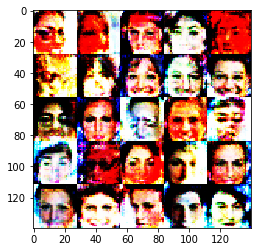

Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.4623
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.5325


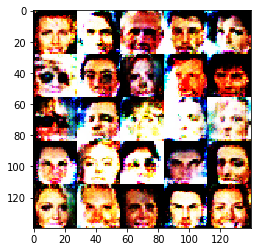

Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.4307
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7184


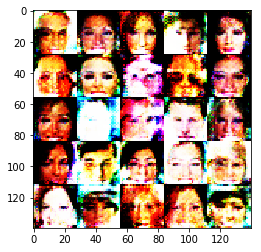

Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.5411
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.6591


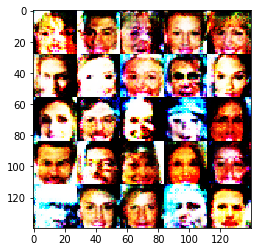

Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.1934... Generator Loss: 0.8766
Epoch 1/1... Discriminator Loss: 1.3162... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.0842... Generator Loss: 0.7753
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.5390
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7576


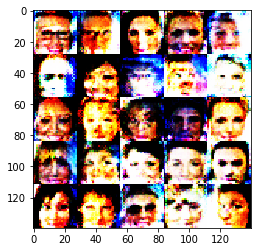

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.5851


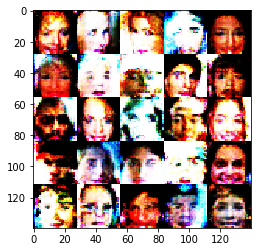

Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.5183
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7305


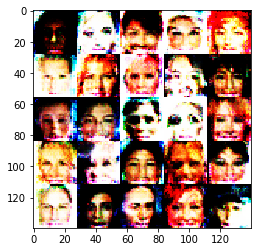

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.